# Imports libraries

In [1]:
import seaborn as sns
import spacy
import re
import os
import numpy as np
import pandas as pd
import copy
!pip install gensim
import gensim
import matplotlib.pyplot as plt

from scipy import sparse
from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from IPython.display import Image
from spacy import displacy
from transformers import pipeline
%matplotlib inline
from nltk import word_tokenize
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from urllib import request
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.svm import SVR

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
import nltk
import warnings
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [3]:
!cp -r ../input/sentence-transformers-dataset/sentence-transformers /tmp/st
!pip install /tmp/st

Processing /tmp/st
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=126132 sha256=59fff8ce3822a113d4ff1872bdbb07b58bacfa0849ac2e659a9a8d81a54a0df1
  Stored in directory: /tmp/pip-ephem-wheel-cache-re60355j/wheels/75/66/b4/7e3615e01e698b0515db7fe537d95df69218ed36339b7dfb5d
Successfully built sentence-transformers


In [4]:
from sentence_transformers import SentenceTransformer, util

# Data Understanding

In [5]:
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")

In [6]:
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [7]:
summaries_test.head()

student_id prompt_id            text
0  000000ffffff    abc123  Example text 1
1  111111eeeeee    def789  Example text 2
2  222222cccccc    abc123  Example text 3
3  333333dddddd    def789  Example text 4

In [8]:
prompts_train.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [9]:
prompts_test.head()

prompt_id prompt_question     prompt_title       prompt_text
0    abc123    Summarize...  Example Title 1  Heading\nText...
1    def789    Summarize...  Example Title 2  Heading\nText...

In [10]:
sample_submission.head()

student_id  content  wording
0  000000ffffff      0.0      0.0
1  111111eeeeee      0.0      0.0
2  222222cccccc      0.0      0.0
3  333333dddddd      0.0      0.0

In [11]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [12]:
summaries_test.dtypes

student_id    object
prompt_id     object
text          object
dtype: object

In [13]:
prompts_train.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [14]:
prompts_test.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [15]:
sample_submission.dtypes

student_id     object
content       float64
wording       float64
dtype: object

****
1. Test dataset hasn't any real data, so we need to made validation dataset by hand.

****

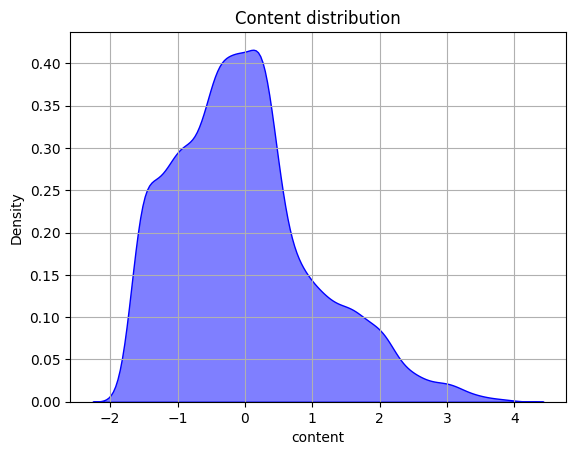

In [16]:
sns.kdeplot(data = summaries_train, x = "content", color = "b", alpha = .5, fill = True)
plt.title("Content distribution")
plt.grid()

boxplots

<Axes: xlabel='content'>

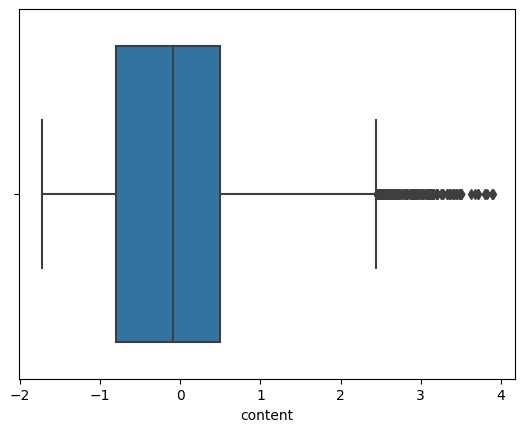

In [17]:
sns.boxplot(x = summaries_train['content'])

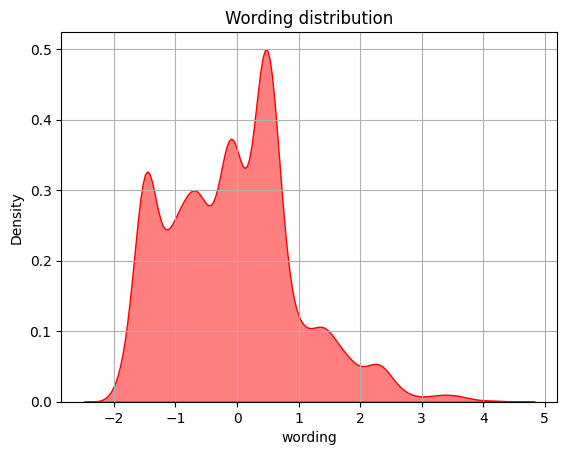

In [18]:
sns.kdeplot(data = summaries_train, x = "wording",color = "r", alpha = .5, fill = True)
plt.title("Wording distribution")
plt.grid()

<Axes: xlabel='wording'>

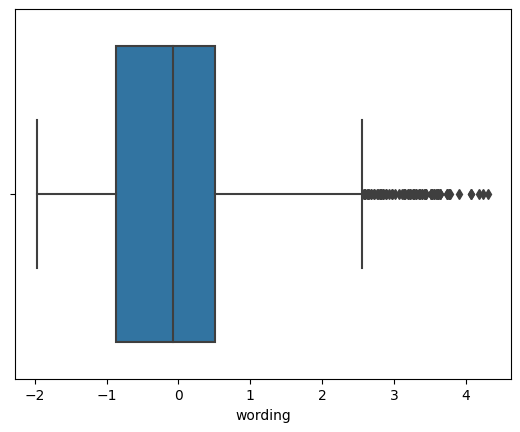

In [19]:
sns.boxplot(x = summaries_train['wording'])

In [20]:
Q1 = summaries_train['wording'].quantile(0.25)
Q3 = summaries_train['wording'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only the rows within the bounds
summaries_train = summaries_train[(summaries_train['wording'] >= lower_bound) & (summaries_train['wording'] <= upper_bound)]

In [21]:
Q1 = summaries_train['content'].quantile(0.25)
Q3 = summaries_train['content'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only the rows within the bounds
summaries_train = summaries_train[(summaries_train['content'] >= lower_bound) & (summaries_train['content'] <= upper_bound)]

In [22]:
summaries_train = summaries_train.merge(prompts_train , on = "prompt_id")
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0095993991fe    814d6b  The third wave only started as an experiment w...   
2  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
3  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   
4  014e2395b3c4    814d6b  The Thrid Wave movement in the school has more...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  0.205683  0.380538  Summarize how the Third Wave developed over su...   
2  0.567975  0.969062  Summarize how the Third Wave developed over su...   
3 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   
4  1.376083  2.389443  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  
0  The Third Wave  Background \r\nThe Third Wave experiment took ...  
1  The Third Wave  Background \r\nThe Third Wave experiment took ...  
2  The Third Wave  Background \r\nThe Third Wave experiment took ...  
3  The Third Wave  Background \r\nThe Third Wave experiment took ...  
4  The Third Wave  Background \r\nThe Third Wave experiment took ...

In [23]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def count_stopwords(text, stopwords):
    split = text.lower().split(' ')
    count = 0
    for i in split:
        if i in stopwords:
            count += 1
    return count


In [24]:
summaries_train["stopwords"] = summaries_train['text'].apply(count_stopwords, stopwords = stop_words)
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0095993991fe    814d6b   
2     00c20c6ddd23    814d6b   
3     00d40ad10dc9    814d6b   
4     014e2395b3c4    814d6b   
...            ...       ...   
6947  fef3e85236e5    39c16e   
6948  ff0f65eecf02    39c16e   
6949  ff186473ea0a    39c16e   
6950  ff5e9e6068da    39c16e   
6951  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The third wave only started as an experiment w...  0.205683  0.380538   
2     The experimen was orginally about how even whe...  0.567975  0.969062   
3     The third wave developed so quickly due to the... -0.910596 -0.081769   
4     The Thrid Wave movement in the school has more...  1.376083  2.389443   
...                                                 ...       ...       ...   
6947  It has to be made on a complex storyline, with... -0.981265 -1.548900   
6948  Aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
6949  A tragedy should have a complex plan not a sim... -0.834946 -0.593749   
6950  Aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
6951  An ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question    prompt_title  \
0     Summarize how the Third Wave developed over su...  The Third Wave   
1     Summarize how the Third Wave developed over su...  The Third Wave   
2     Summarize how the Third Wave developed over su...  The Third Wave   
3     Summarize how the Third Wave developed over su...  The Third Wave   
4     Summarize how the Third Wave developed over su...  The Third Wave   
...                                                 ...             ...   
6947  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6948  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6949  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6950  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6951  Summarize at least 3 elements of an ideal trag...      On Tragedy   

                                            prompt_text  stopwords  
0     Background \r\nThe Third Wave experiment took ...         25  
1     Background \r\nThe Third Wave experiment took ...         27  
2     Background \r\nThe Third Wave experiment took ...         35  
3     Background \r\nThe Third Wave experiment took ...         12  
4     Background \r\nThe Third Wave experiment took ...         67  
...                                                 ...        ...  
6947  Chapter 13 \r\nAs the sequel to what has alrea...         16  
6948  Chapter 13 \r\nAs the sequel to what has alrea...         15  
6949  Chapter 13 \r\nAs the sequel to what has alrea...         16  
6950  Chapter 13 \r\nAs the sequel to what has alrea...         22  
6951  Chapter 13 \r\nAs the sequel to what has alrea...         27  

[6952 rows x 9 columns]

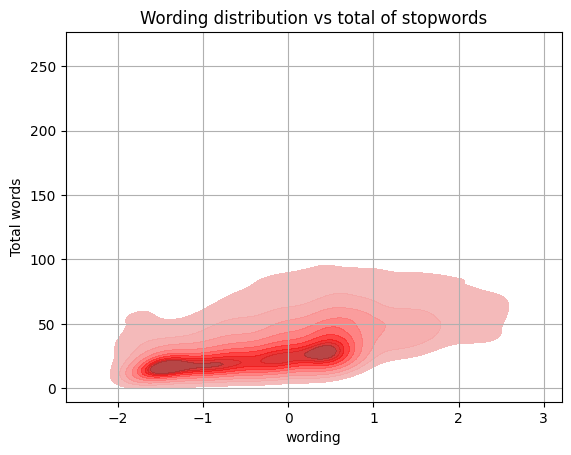

In [25]:
sns.kdeplot(data = summaries_train, x = "wording", y = "stopwords",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of stopwords")
plt.ylabel("Total words")
plt.grid()

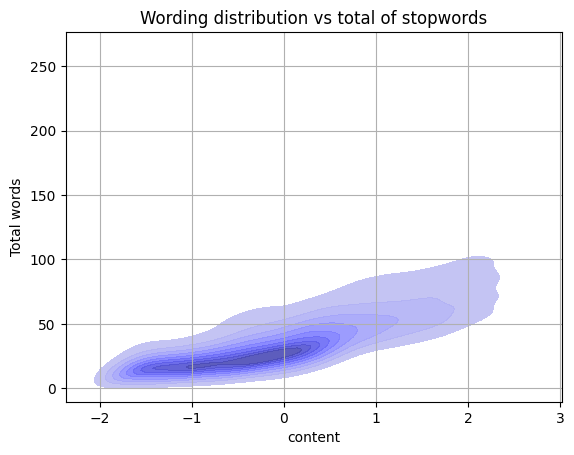

In [26]:
sns.kdeplot(data = summaries_train, x = "content", y = "stopwords",color = "b", alpha = .9, fill = True)
plt.title("Wording distribution vs total of stopwords")
plt.ylabel("Total words")
plt.grid()

In [27]:
summaries_train["punctuation"] = summaries_train['text'].str.count(r'[\.,\n]')
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0095993991fe    814d6b   
2     00c20c6ddd23    814d6b   
3     00d40ad10dc9    814d6b   
4     014e2395b3c4    814d6b   
...            ...       ...   
6947  fef3e85236e5    39c16e   
6948  ff0f65eecf02    39c16e   
6949  ff186473ea0a    39c16e   
6950  ff5e9e6068da    39c16e   
6951  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The third wave only started as an experiment w...  0.205683  0.380538   
2     The experimen was orginally about how even whe...  0.567975  0.969062   
3     The third wave developed so quickly due to the... -0.910596 -0.081769   
4     The Thrid Wave movement in the school has more...  1.376083  2.389443   
...                                                 ...       ...       ...   
6947  It has to be made on a complex storyline, with... -0.981265 -1.548900   
6948  Aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
6949  A tragedy should have a complex plan not a sim... -0.834946 -0.593749   
6950  Aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
6951  An ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question    prompt_title  \
0     Summarize how the Third Wave developed over su...  The Third Wave   
1     Summarize how the Third Wave developed over su...  The Third Wave   
2     Summarize how the Third Wave developed over su...  The Third Wave   
3     Summarize how the Third Wave developed over su...  The Third Wave   
4     Summarize how the Third Wave developed over su...  The Third Wave   
...                                                 ...             ...   
6947  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6948  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6949  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6950  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6951  Summarize at least 3 elements of an ideal trag...      On Tragedy   

                                            prompt_text  stopwords  \
0     Background \r\nThe Third Wave experiment took ...         25   
1     Background \r\nThe Third Wave experiment took ...         27   
2     Background \r\nThe Third Wave experiment took ...         35   
3     Background \r\nThe Third Wave experiment took ...         12   
4     Background \r\nThe Third Wave experiment took ...         67   
...                                                 ...        ...   
6947  Chapter 13 \r\nAs the sequel to what has alrea...         16   
6948  Chapter 13 \r\nAs the sequel to what has alrea...         15   
6949  Chapter 13 \r\nAs the sequel to what has alrea...         16   
6950  Chapter 13 \r\nAs the sequel to what has alrea...         22   
6951  Chapter 13 \r\nAs the sequel to what has alrea...         27   

      punctuation  
0               3  
1               5  
2               8  
3               2  
4               5  
...           ...  
6947            1  
6948            3  
6949            3  
6950            4  
6951            4  

[6952 rows x 10 columns]

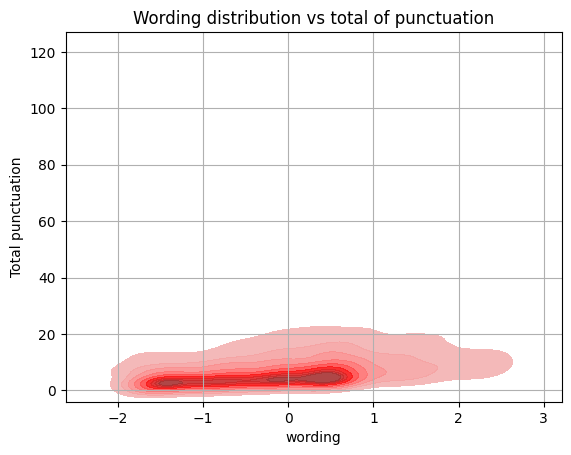

In [28]:
sns.kdeplot(data = summaries_train, x = "wording", y = "punctuation",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of punctuation")
plt.ylabel("Total punctuation")
plt.grid()

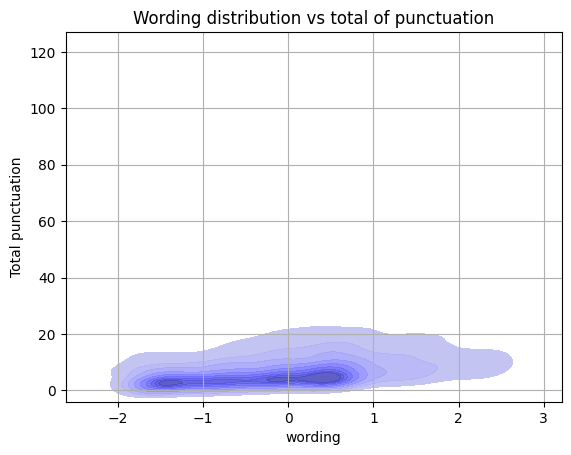

In [29]:
sns.kdeplot(data = summaries_train, x = "wording", y = "punctuation",color = "b", alpha = .9, fill = True)
plt.title("Wording distribution vs total of punctuation")
plt.ylabel("Total punctuation")
plt.grid()

# EDA

In [30]:
profile = ProfileReport(summaries_train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
summaries_train['text'] = summaries_train['text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex = True)
summaries_train['prompt_text'] = summaries_train['prompt_text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex = True)
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0095993991fe    814d6b   
2     00c20c6ddd23    814d6b   
3     00d40ad10dc9    814d6b   
4     014e2395b3c4    814d6b   
...            ...       ...   
6947  fef3e85236e5    39c16e   
6948  ff0f65eecf02    39c16e   
6949  ff186473ea0a    39c16e   
6950  ff5e9e6068da    39c16e   
6951  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     the third wave was an experimentto see how peo...  0.205683  0.380538   
1     the third wave only started as an experiment w...  0.205683  0.380538   
2     the experimen was orginally about how even whe...  0.567975  0.969062   
3     the third wave developed so quickly due to the... -0.910596 -0.081769   
4     the thrid wave movement in the school has more...  1.376083  2.389443   
...                                                 ...       ...       ...   
6947  it has to be made on a complex storyline  with... -0.981265 -1.548900   
6948  aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
6949  a tragedy should have a complex plan not a sim... -0.834946 -0.593749   
6950  aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
6951  an ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question    prompt_title  \
0     Summarize how the Third Wave developed over su...  The Third Wave   
1     Summarize how the Third Wave developed over su...  The Third Wave   
2     Summarize how the Third Wave developed over su...  The Third Wave   
3     Summarize how the Third Wave developed over su...  The Third Wave   
4     Summarize how the Third Wave developed over su...  The Third Wave   
...                                                 ...             ...   
6947  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6948  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6949  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6950  Summarize at least 3 elements of an ideal trag...      On Tragedy   
6951  Summarize at least 3 elements of an ideal trag...      On Tragedy   

                                            prompt_text  stopwords  \
0     background  the third wave experiment took pla...         25   
1     background  the third wave experiment took pla...         27   
2     background  the third wave experiment took pla...         35   
3     background  the third wave experiment took pla...         12   
4     background  the third wave experiment took pla...         67   
...                                                 ...        ...   
6947  chapter 13  as the sequel to what has already ...         16   
6948  chapter 13  as the sequel to what has already ...         15   
6949  chapter 13  as the sequel to what has already ...         16   
6950  chapter 13  as the sequel to what has already ...         22   
6951  chapter 13  as the sequel to what has already ...         27   

      punctuation  
0               3  
1               5  
2               8  
3               2  
4               5  
...           ...  
6947            1  
6948            3  
6949            3  
6950            4  
6951            4  

[6952 rows x 10 columns]

In [32]:
def preprocess_hard(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and
            # len(token) > 2 and
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

****I had a problem with installing nltk, because I can't use internet at kaggle competitions. Unfortunately, I didn't use clean_text function****

In [33]:
'''wnl = WordNetLemmatizer()

def clean_text(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [wnl.lemmatize(word) for word in text if word not in stopwords.words('english')]
    text = " ".join(text)
    
    return text'''

'wnl = WordNetLemmatizer()\n\ndef clean_text(text):\n    text = re.sub("[^a-zA-Z]", " ", text)\n    text = text.lower().split()\n    text = [wnl.lemmatize(word) for word in text if word not in stopwords.words(\'english\')]\n    text = " ".join(text)\n    \n    return text'

In [34]:
summaries_train["text_without_stopwords"] = summaries_train['text'].apply(lambda x : preprocess_hard(x))
summaries_train["prompt_text"] = summaries_train['prompt_text'].apply(lambda x : preprocess_hard(x))
summaries_train["prompt_question"] = summaries_train['prompt_question'].apply(lambda x : preprocess_hard(x))
summaries_train["prompt_title"] = summaries_train['prompt_title'].apply(lambda x : preprocess_hard(x))

In [35]:
summaries_train["count_t"] = summaries_train["text_without_stopwords"].str.split().str.len() 
summaries_train["count_p"] = summaries_train["prompt_text"].str.split().str.len()
summaries_train["length_symbols"] = summaries_train["text_without_stopwords"].apply(len)
summaries_train["count_tp"] = summaries_train["count_t"] / summaries_train["count_p"]
summaries_train["mean_word_length"] = (summaries_train["length_symbols"] - summaries_train['count_t'] + 1) / summaries_train['count_t']

summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0095993991fe    814d6b   
2     00c20c6ddd23    814d6b   
3     00d40ad10dc9    814d6b   
4     014e2395b3c4    814d6b   
...            ...       ...   
6947  fef3e85236e5    39c16e   
6948  ff0f65eecf02    39c16e   
6949  ff186473ea0a    39c16e   
6950  ff5e9e6068da    39c16e   
6951  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     the third wave was an experimentto see how peo...  0.205683  0.380538   
1     the third wave only started as an experiment w...  0.205683  0.380538   
2     the experimen was orginally about how even whe...  0.567975  0.969062   
3     the third wave developed so quickly due to the... -0.910596 -0.081769   
4     the thrid wave movement in the school has more...  1.376083  2.389443   
...                                                 ...       ...       ...   
6947  it has to be made on a complex storyline  with... -0.981265 -1.548900   
6948  aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
6949  a tragedy should have a complex plan not a sim... -0.834946 -0.593749   
6950  aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
6951  an ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question prompt_title  \
0     summarize wave developed short period time exp...         wave   
1     summarize wave developed short period time exp...         wave   
2     summarize wave developed short period time exp...         wave   
3     summarize wave developed short period time exp...         wave   
4     summarize wave developed short period time exp...         wave   
...                                                 ...          ...   
6947  summarize elements ideal tragedy described ari...      tragedy   
6948  summarize elements ideal tragedy described ari...      tragedy   
6949  summarize elements ideal tragedy described ari...      tragedy   
6950  summarize elements ideal tragedy described ari...      tragedy   
6951  summarize elements ideal tragedy described ari...      tragedy   

                                            prompt_text  stopwords  \
0     background wave experiment took place cubberle...         25   
1     background wave experiment took place cubberle...         27   
2     background wave experiment took place cubberle...         35   
3     background wave experiment took place cubberle...         12   
4     background wave experiment took place cubberle...         67   
...                                                 ...        ...   
6947  chapter sequel said proceed consider poet aim ...         16   
6948  chapter sequel said proceed consider poet aim ...         15   
6949  chapter sequel said proceed consider poet aim ...         16   
6950  chapter sequel said proceed consider poet aim ...         22   
6951  chapter sequel said proceed consider poet aim ...         27   

      punctuation                             text_without_stopwords  count_t  \
0               3  wave experimentto people reacted new leader go...       31   
1               5  wave started experiment class slowly spread ki...       27   
2               8  experimen orginally terrible thngs happening f...       32   
3               2  wave developed quickly students particip thos ...       13   
4               5  thrid wave movement school students join perio...       51   
...           ...                                                ...      ...   
6947            1  complex storyline plot makes audience feel pit...       15   
6948            3  aristotle descirbes ideal tradgedy complex pla...       12   
6949            3  tragedy complex plan simple good plot plot exc...       10   
6950            4  aristotle believed ideal tradegy include purga...       27   
6951            4  ideal tragety elements ideal start great trage...       28

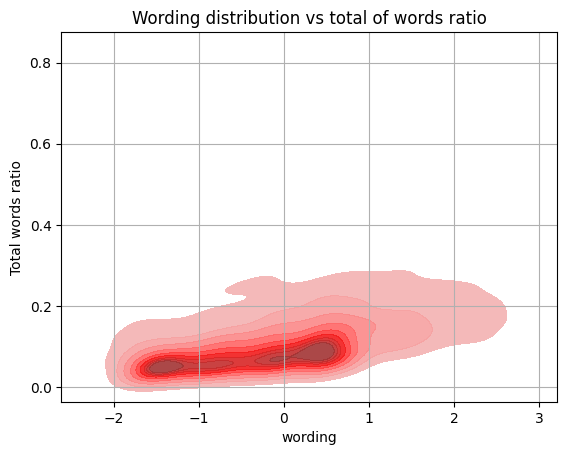

In [36]:
sns.kdeplot(data = summaries_train, x = "wording", y = "count_tp",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of words ratio")
plt.ylabel("Total words ratio")
plt.grid()

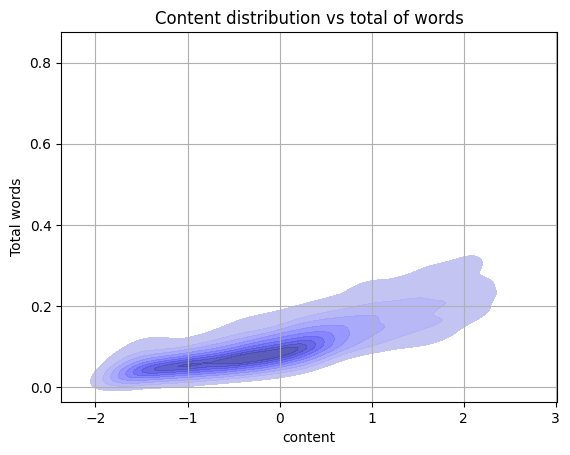

In [37]:
sns.kdeplot(data = summaries_train, x = "content", y = "count_tp",color = "b", alpha = .9, fill = True)
plt.title("Content distribution vs total of words")
plt.ylabel("Total words")
plt.grid()

In [38]:
idx = 10

print(
    f"Before : {summaries_train['text'].iloc[idx]}\n"
    f"Hard Processing : {summaries_train['text_without_stopwords'].iloc[idx]}\n"
)

idx = 100

print(
    f"Before : {summaries_train['text'].iloc[idx]}\n"
    f"Hard Processing : {summaries_train['text_without_stopwords'].iloc[idx]}\n"
)

Before : the third wave started to get many students to join the group  mr  jones decided to terminate the movement because it was getting out of contro  
Hard Processing : wave started students join group mr jones decided terminate movement getting contro

Before : the third wave developed over a short period of time because people felt like they had to join and it ended because it got out of controll  in the text it says   and by the end of the day the movement had over 200 participants  also it says    jones felt it was slipping out of control  this is showing that so many people joned so quick it got out of controll and it became big becasue so many people convinced them to join 
Hard Processing : wave developed short period time people felt like join ended got controll text says end day movement participants says jones felt slipping control showing people joned quick got controll big becasue people convinced join



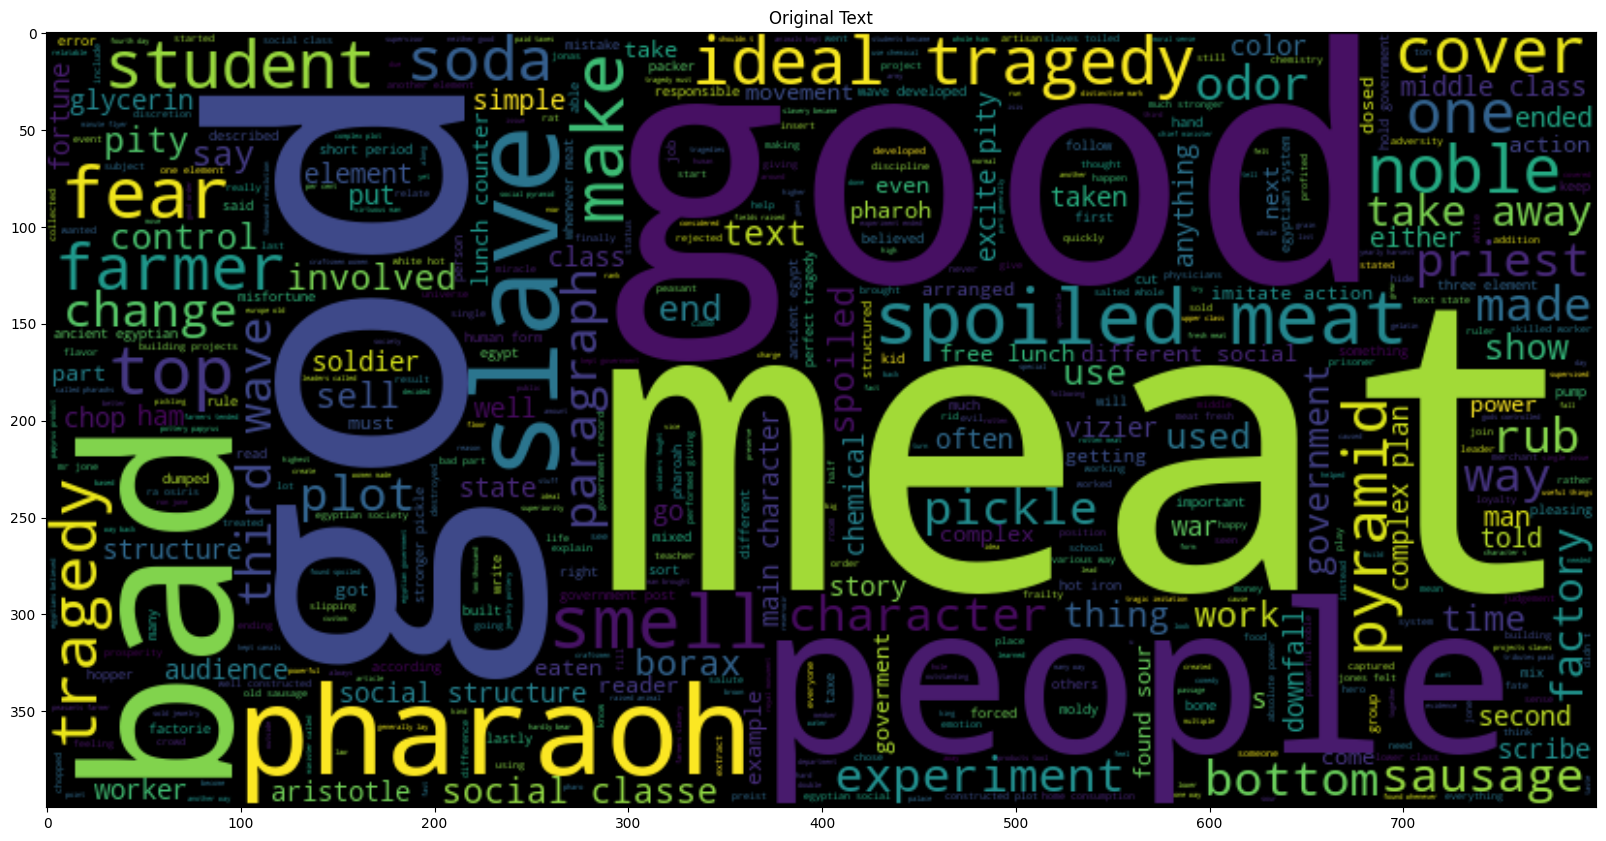

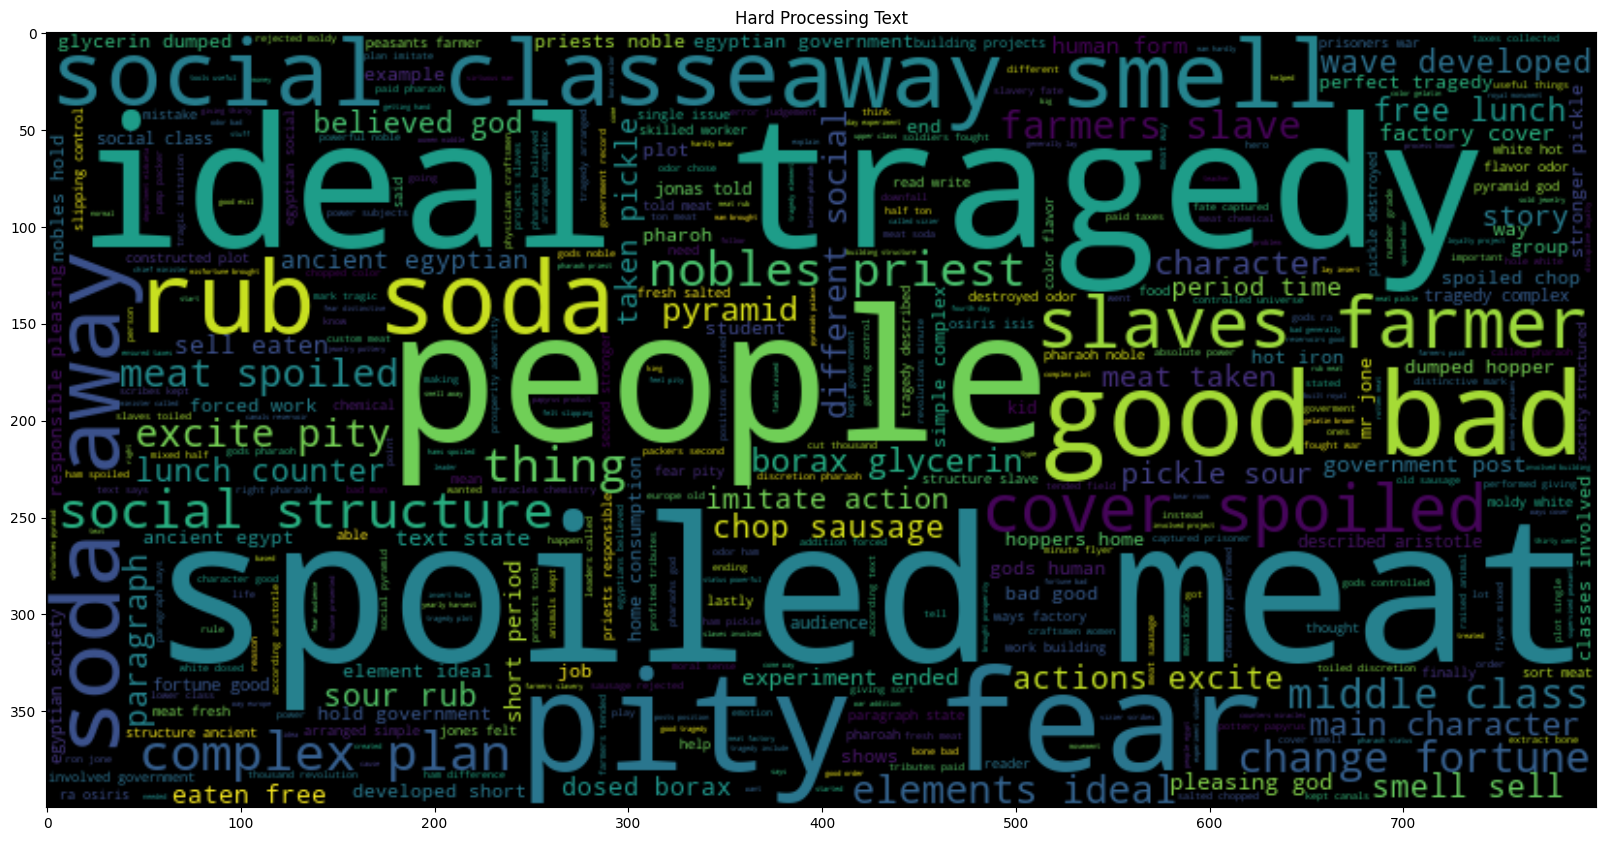

In [39]:
plt.figure(figsize = (20, 20)) 
plt.title("Original Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train['text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20, 20)) 
plt.title("Hard Processing Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train['text_without_stopwords']))
plt.imshow(wc, interpolation = 'bilinear')

In [40]:
summaries_train['prompt_merged_text'] = summaries_train['prompt_title'] + '\n' + summaries_train['prompt_question'] + '\n' + summaries_train['prompt_text']
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0095993991fe    814d6b   
2     00c20c6ddd23    814d6b   
3     00d40ad10dc9    814d6b   
4     014e2395b3c4    814d6b   
...            ...       ...   
6947  fef3e85236e5    39c16e   
6948  ff0f65eecf02    39c16e   
6949  ff186473ea0a    39c16e   
6950  ff5e9e6068da    39c16e   
6951  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     the third wave was an experimentto see how peo...  0.205683  0.380538   
1     the third wave only started as an experiment w...  0.205683  0.380538   
2     the experimen was orginally about how even whe...  0.567975  0.969062   
3     the third wave developed so quickly due to the... -0.910596 -0.081769   
4     the thrid wave movement in the school has more...  1.376083  2.389443   
...                                                 ...       ...       ...   
6947  it has to be made on a complex storyline  with... -0.981265 -1.548900   
6948  aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
6949  a tragedy should have a complex plan not a sim... -0.834946 -0.593749   
6950  aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
6951  an ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question prompt_title  \
0     summarize wave developed short period time exp...         wave   
1     summarize wave developed short period time exp...         wave   
2     summarize wave developed short period time exp...         wave   
3     summarize wave developed short period time exp...         wave   
4     summarize wave developed short period time exp...         wave   
...                                                 ...          ...   
6947  summarize elements ideal tragedy described ari...      tragedy   
6948  summarize elements ideal tragedy described ari...      tragedy   
6949  summarize elements ideal tragedy described ari...      tragedy   
6950  summarize elements ideal tragedy described ari...      tragedy   
6951  summarize elements ideal tragedy described ari...      tragedy   

                                            prompt_text  stopwords  \
0     background wave experiment took place cubberle...         25   
1     background wave experiment took place cubberle...         27   
2     background wave experiment took place cubberle...         35   
3     background wave experiment took place cubberle...         12   
4     background wave experiment took place cubberle...         67   
...                                                 ...        ...   
6947  chapter sequel said proceed consider poet aim ...         16   
6948  chapter sequel said proceed consider poet aim ...         15   
6949  chapter sequel said proceed consider poet aim ...         16   
6950  chapter sequel said proceed consider poet aim ...         22   
6951  chapter sequel said proceed consider poet aim ...         27   

      punctuation                             text_without_stopwords  count_t  \
0               3  wave experimentto people reacted new leader go...       31   
1               5  wave started experiment class slowly spread ki...       27   
2               8  experimen orginally terrible thngs happening f...       32   
3               2  wave developed quickly students particip thos ...       13   
4               5  thrid wave movement school students join perio...       51   
...           ...                                                ...      ...   
6947            1  complex storyline plot makes audience feel pit...       15   
6948            3  aristotle descirbes ideal tradgedy complex pla...       12   
6949            3  tragedy complex plan simple good plot plot exc...       10   
6950            4  aristotle believed ideal tradegy include purga...       27   
6951            4  ideal tragety elements ideal start great trage...       28

# Modeling

In [41]:
models = {
    'SVR': Pipeline([  
        ('classifier', SVR())
    ]),
    'gradient_boosting': Pipeline([  
        ('classifier', GradientBoostingRegressor(n_estimators = 100, max_depth = 7, loss='huber', learning_rate= 0.1, min_samples_split = 10, min_samples_leaf=10, subsample = 0.8))
    ])
}

In [42]:
warnings.filterwarnings("ignore")

# TASK 2

In [44]:
results = []

for model_name, model in models.items():
    scores = []
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    dummy_labels = np.zeros(len(summaries_train))
    
    for train_ind, test_ind in cv.split(summaries_train, dummy_labels):
        reviews_train = summaries_train.iloc[train_ind]
        reviews_test = summaries_train.iloc[test_ind]
        
        scaler = RobustScaler()

        y_train_content = scaler.fit_transform(reviews_train[['content']])
        y_test_content = scaler.transform(reviews_test[['content']])

        y_train_wording = scaler.fit_transform(reviews_train[['wording']])
        y_test_wording = scaler.transform(reviews_test[['wording']])
        
        transformer = SentenceTransformer('../input/sentence/all-MiniLM-L6-v2', device='cuda')
        
        reviews_train.reset_index(drop=True, inplace=True)
        reviews_test.reset_index(drop=True, inplace=True)

        prompt_text_embeddings_train = transformer.encode(reviews_train['prompt_merged_text'])
        clear_text_embeddings_train = transformer.encode(reviews_train['text_without_stopwords'])
        prompt_text_embeddings_test = transformer.encode(reviews_test['prompt_merged_text'])
        clear_text_embeddings_test = transformer.encode(reviews_test['text_without_stopwords'])
        
        for i, prompt_id in enumerate(reviews_train['prompt_id'].unique()):
            temp_sum = clear_text_embeddings_train[reviews_train[reviews_train['prompt_id'] == prompt_id].index]
            temp_tex = prompt_text_embeddings_train[i]
            reviews_train.loc[reviews_train['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
    
        for i, prompt_id in enumerate(reviews_test['prompt_id'].unique()):
            temp_sum = clear_text_embeddings_test[reviews_test[reviews_test['prompt_id'] == prompt_id].index]
            temp_tex = prompt_text_embeddings_test[i]
            reviews_test.loc[reviews_test['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
            
            
        reviews_train.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.fit_transform(reviews_train[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])

        reviews_test.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.transform(reviews_test[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])
      
        vectorizer = TfidfVectorizer(analyzer = 'word', lowercase=True)
        
        train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

        test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

        X_train = sparse.hstack((
                    train_summaries_vectors,
                    sparse.coo_matrix(reviews_train[['mean_word_length','count_p', 'stopwords', 'punctuation', 'tex_score']].to_numpy())
                ))
        X_test = sparse.hstack((
                    test_summaries_vectors,
                    sparse.coo_matrix(reviews_test[['mean_word_length','count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())
                ))
    
        model_c = copy.deepcopy(model)
        model_c.fit(X_train, y_train_content)
        prediction_test_content = model_c.predict(X_test)
        
        
        train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

        test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

        X_train = sparse.hstack((
                    train_summaries_vectors,
                    sparse.coo_matrix(reviews_train[['mean_word_length']].to_numpy())
                ))
        
        X_test = sparse.hstack((
            test_summaries_vectors,
            sparse.coo_matrix(reviews_test[['mean_word_length']].to_numpy())
        ))
        
        model_w = copy.deepcopy(model)
        model_w.fit(X_train, y_train_wording)        
        prediction_test_wording = model_w.predict(X_test)
        
        rmse_c = np.sqrt(mean_squared_error(prediction_test_content, y_test_content))
        rmse_w = np.sqrt(mean_squared_error(prediction_test_wording, y_test_wording))
        scores.append((rmse_c + rmse_w) / 2)
        
    scores = np.array(scores)
    avg_score = round(scores.mean(), 4)
    std_score = round(scores.std(), 4)
    min_score = round(scores.min(), 4)
    max_score = round(scores.max(), 4)
    score_lower_bound = round(avg_score - 3*std_score, 4)
    score_higher_bound = round(avg_score + 3*std_score, 4)
    
    results.append({
        'experiment': model_name,
        'mcrmse_avg': avg_score,
        'mcrmse_std': std_score,
        'mcrmse_min': min_score,
        'mcrmse_max': max_score,
        'mcrmse_lower_bound_estimation': score_lower_bound,
        'mcrmse_higher_bound_estimation': score_higher_bound
    })
    
results = pd.DataFrame(results).sort_values('mcrmse_avg')
results

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

experiment  mcrmse_avg  mcrmse_std  mcrmse_min  mcrmse_max  \
1  gradient_boosting      0.4352      0.0132      0.4204      0.4582   
0                SVR      0.4378      0.0091      0.4286      0.4540   

   mcrmse_lower_bound_estimation  mcrmse_higher_bound_estimation  
1                         0.3956                          0.4748  
0                         0.4105                          0.4651

In [74]:
results = []

for model_name, model in models.items():
    scores = []
    group_kfold  = GroupKFold(n_splits = 4)
    dummy_labels = np.zeros(len(summaries_train))
    
    for train_ind, test_ind in group_kfold.split(summaries_train, dummy_labels, groups = summaries_train.prompt_id):
        reviews_train = summaries_train.iloc[train_ind]
        reviews_test = summaries_train.iloc[test_ind]
        scaler = RobustScaler()

        y_train_content = scaler.fit_transform(reviews_train[['content']])
        y_test_content = scaler.transform(reviews_test[['content']])

        y_train_wording = scaler.fit_transform(reviews_train[['wording']])
        y_test_wording = scaler.transform(reviews_test[['wording']])
        
        transformer = SentenceTransformer('../input/sentence/all-MiniLM-L6-v2', device='cuda')
        
        reviews_train.reset_index(drop=True, inplace=True)
        reviews_test.reset_index(drop=True, inplace=True)

        prompt_text_embeddings_train = transformer.encode(reviews_train['prompt_merged_text'])
        clear_text_embeddings_train = transformer.encode(reviews_train['text_without_stopwords'])
        prompt_text_embeddings_test = transformer.encode(reviews_test['prompt_merged_text'])
        clear_text_embeddings_test = transformer.encode(reviews_test['text_without_stopwords'])
        
        for i, prompt_id in enumerate(reviews_train['prompt_id'].unique()):
            temp_sum = clear_text_embeddings_train[reviews_train[reviews_train['prompt_id'] == prompt_id].index]
            temp_tex = prompt_text_embeddings_train[i]
            reviews_train.loc[reviews_train['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
    
        for i, prompt_id in enumerate(reviews_test['prompt_id'].unique()):
            temp_sum = clear_text_embeddings_test[reviews_test[reviews_test['prompt_id'] == prompt_id].index]
            temp_tex = prompt_text_embeddings_test[i]
            reviews_test.loc[reviews_test['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
            
            
        reviews_train.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.fit_transform(reviews_train[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])

        reviews_test.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.transform(reviews_test[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])
      
        vectorizer = TfidfVectorizer(analyzer = 'word', lowercase=True)
        
        train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

        test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

        X_train = sparse.hstack((
                    train_summaries_vectors,
                    sparse.coo_matrix(reviews_train[['mean_word_length','count_p', 'stopwords', 'punctuation', 'tex_score']].to_numpy())
                ))
        X_test = sparse.hstack((
                    test_summaries_vectors,
                    sparse.coo_matrix(reviews_test[['mean_word_length','count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())
                ))
    
        model_c = copy.deepcopy(model)
        model_c.fit(X_train, y_train_content)
        prediction_test_content = model_c.predict(X_test)
        
        
        train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

        test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

        X_train = sparse.hstack((
                    train_summaries_vectors,
                    sparse.coo_matrix(reviews_train[['mean_word_length']].to_numpy())
                ))
        
        X_test = sparse.hstack((
            test_summaries_vectors,
            sparse.coo_matrix(reviews_test[['mean_word_length']].to_numpy())
        ))
        
        model_w = copy.deepcopy(model)
        model_w.fit(X_train, y_train_wording)        
        prediction_test_wording = model_w.predict(X_test)
        
        rmse_c = np.sqrt(mean_squared_error(prediction_test_content, y_test_content))
        rmse_w = np.sqrt(mean_squared_error(prediction_test_wording, y_test_wording))
        scores.append((rmse_c + rmse_w) / 2)
        
    scores = np.array(scores)
    avg_score = round(scores.mean(), 4)
    std_score = round(scores.std(), 4)
    min_score = round(scores.min(), 4)
    max_score = round(scores.max(), 4)
    score_lower_bound = round(avg_score - 3*std_score, 4)
    score_higher_bound = round(avg_score + 3*std_score, 4)
    
    results.append({
        'experiment': model_name,
        'mcrmse_avg': avg_score,
        'mcrmse_std': std_score,
        'mcrmse_min': min_score,
        'mcrmse_max': max_score,
        'mcrmse_lower_bound_estimation': score_lower_bound,
        'mcrmse_higher_bound_estimation': score_higher_bound
    })
    
results = pd.DataFrame(results).sort_values('mcrmse_avg')
results

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/156 [00:00<?, ?it/s]

Batches:   0%|          | 0/156 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/185 [00:00<?, ?it/s]

Batches:   0%|          | 0/185 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/156 [00:00<?, ?it/s]

Batches:   0%|          | 0/156 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/185 [00:00<?, ?it/s]

Batches:   0%|          | 0/185 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

experiment  mcrmse_avg  mcrmse_std  mcrmse_min  mcrmse_max  \
1  gradient_boosting       0.561      0.0582      0.5145      0.6607   
0                SVR       0.602      0.0605      0.5457      0.7038   

   mcrmse_lower_bound_estimation  mcrmse_higher_bound_estimation  
1                         0.3864                          0.7356  
0                         0.4205                          0.7835

**Summary: I try regular K-Fold and Group K-Fold at the same time for saving attempts in Kaggle. I got next situation: GradientBoosting has 0.4352 score with Stratified validation, 0.5 with Group validation. Therefore, in our situation, it is better to use the group validation, since this result is closer to the result of LB(0.982). This makes sense since we have a situation where our data set is split into prompts. 
I don't have a match in terms of absolute values of F1 metric for Stratified K-Fold and Group K-Fold, but I had a local validation matches LB in terms of gain correlation between experiments: my gradient boost result changed after changing the hyperparameters (see figure). Also, I had an SVR in validation of about 0.602 in group validation and 0.4378 in stratified validation, and that's higher than gradient_boosting, and in LB I also got that SVR higher than Gradient Boosting, so we have a correlation - it's good news.
Problems related to the conversion of mine mode, although I don't have an absolute match on the values, I do have a correlation between the variables that is much better. 
If I was solving such a problem in production, I would use group validation split, maybe by questions and students at the same time, since they change at the same time. 
I didn't have time to do enough experiments, so I draw conclusions from what I have.**

#after sending answer, that i got
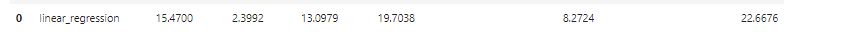

SVR


Gradient Boosting at homework2


Gradient Boosting



LinearRegression
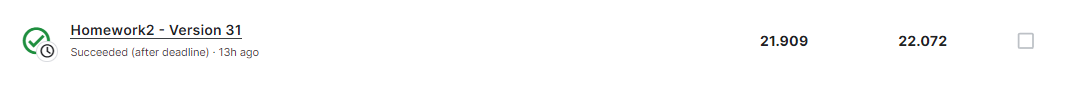

In [46]:
reviews_train = copy.deepcopy(summaries_train)
#reviews_test = summaries_train[summaries_train.prompt_id == '3b9047']

In [47]:
scaler = RobustScaler()

y_train_content = scaler.fit_transform(reviews_train[['content']])
#y_test_content = scaler.transform(reviews_test[['content']])

y_train_wording = scaler.fit_transform(reviews_train[['wording']])
#y_test_wording = scaler.transform(reviews_test[['wording']])

In [48]:
model = SentenceTransformer('../input/sentence/all-MiniLM-L6-v2', device='cuda')

In [49]:
reviews_train.reset_index(drop=True, inplace=True)
#reviews_test.reset_index(drop=True, inplace=True)

In [50]:
prompt_text_embeddings_train = model.encode(reviews_train['prompt_merged_text'])
clear_text_embeddings_train = model.encode(reviews_train['text_without_stopwords'])
#prompt_text_embeddings_test = model.encode(reviews_test['prompt_merged_text'])
#clear_text_embeddings_test = model.encode(reviews_test['text_without_stopwords'])

Batches:   0%|          | 0/218 [00:00<?, ?it/s]

Batches:   0%|          | 0/218 [00:00<?, ?it/s]

In [51]:
for i, prompt_id in enumerate(reviews_train['prompt_id'].unique()):
    temp_sum = clear_text_embeddings_train[reviews_train[reviews_train['prompt_id'] == prompt_id].index]
    temp_tex = prompt_text_embeddings_train[i]
    reviews_train.loc[reviews_train['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))
    
'''for i, prompt_id in enumerate(reviews_test['prompt_id'].unique()):
    temp_sum = clear_text_embeddings_test[reviews_test[reviews_test['prompt_id'] == prompt_id].index]
    temp_tex = prompt_text_embeddings_test[i]
    reviews_test.loc[reviews_test['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))'''

'for i, prompt_id in enumerate(reviews_test[\'prompt_id\'].unique()):\n    temp_sum = clear_text_embeddings_test[reviews_test[reviews_test[\'prompt_id\'] == prompt_id].index]\n    temp_tex = prompt_text_embeddings_test[i]\n    reviews_test.loc[reviews_test[\'prompt_id\'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))'

In [52]:
reviews_train.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.fit_transform(reviews_train[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])

# For test set
#reviews_test.loc[:, ['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']] = scaler.transform(reviews_test[['mean_word_length', 'count_t', 'count_p', 'count_tp', 'stopwords', 'punctuation', 'tex_score']])'''

In [53]:
reviews_train[['content', 'wording', 'tex_score']].corr()

content   wording  tex_score
content    1.000000  0.717217   0.220826
wording    0.717217  1.000000   0.338444
tex_score  0.220826  0.338444   1.000000

In [54]:
vectorizer = TfidfVectorizer(analyzer='word', lowercase=True)
train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

#test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(reviews_train[['mean_word_length','count_p', 'stopwords', 'punctuation', 'tex_score']].to_numpy())
        ))
'''X_test = sparse.hstack((
            test_summaries_vectors,
            sparse.coo_matrix(reviews_test[['mean_word_length','count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())
        ))'''

"X_test = sparse.hstack((\n            test_summaries_vectors,\n            sparse.coo_matrix(reviews_test[['mean_word_length','count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())\n        ))"

**I had used a RandomizedSearchCV for searhing best hyperparameters, so these parameters are in arguments for GradientBoostingRegressor, but after when I got the parameters, they called overfitting, so I little tweaked them by hand**

In [55]:
model_c =  SVR()

In [57]:
model_c.fit(X_train, y_train_content)

SVR()

In [58]:
'''prediction_train_content = model_c.predict(X_train)
prediction_test_content = model_c.predict(X_test)'''

'prediction_train_content = model_c.predict(X_train)\nprediction_test_content = model_c.predict(X_test)'

In [59]:
train_summaries_vectors = vectorizer.fit_transform(reviews_train['text_without_stopwords'])

#test_summaries_vectors = vectorizer.transform(reviews_test['text_without_stopwords'])

X_train = sparse.hstack((
            train_summaries_vectors,
            sparse.coo_matrix(reviews_train[['mean_word_length']].to_numpy())
        ))

model_w =  SVR()
model_w.fit(X_train, y_train_wording)

SVR()

In [60]:
'''X_test = sparse.hstack((
            test_summaries_vectors,
            sparse.coo_matrix(reviews_test[['mean_word_length']].to_numpy())
        ))'''

"X_test = sparse.hstack((\n            test_summaries_vectors,\n            sparse.coo_matrix(reviews_test[['mean_word_length']].to_numpy())\n        ))"

In [61]:
'''prediction_train_wording = model_w.predict(X_train)
prediction_test_wording = model_w.predict(X_test)'''

'prediction_train_wording = model_w.predict(X_train)\nprediction_test_wording = model_w.predict(X_test)'

# Evaluation

**Content testing**

**Train score**

In [62]:
'''mean_squared_error(prediction_train_content, y_train_content)'''

'mean_squared_error(prediction_train_content, y_train_content)'

**Test score**

In [63]:
'''c1 = mean_squared_error(prediction_test_content, y_test_content)
print(c1)'''

'c1 = mean_squared_error(prediction_test_content, y_test_content)\nprint(c1)'

**Wording testing**

**Train score**

In [64]:
'''mean_squared_error(prediction_train_wording, y_train_wording)'''

'mean_squared_error(prediction_train_wording, y_train_wording)'

**Test score**

In [65]:
'''c2 = mean_squared_error(prediction_test_wording, y_test_wording)
c2'''

'c2 = mean_squared_error(prediction_test_wording, y_test_wording)\nc2'

In [66]:
'''print(f"MCRMSE score = {0.5 * (c1 + c2)}")'''

'print(f"MCRMSE score = {0.5 * (c1 + c2)}")'

In [67]:
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")

In [68]:
summaries_test = summaries_test.merge(prompts_test , on = "prompt_id")

summaries_test['text'] = summaries_test['text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex = True)
summaries_test["text_without_stopwords"] = summaries_test['text'].apply(preprocess_hard)
summaries_test["count_t"] = summaries_test["text_without_stopwords"].str.split().str.len() 
summaries_test["count_p"] = summaries_test["prompt_text"].str.split().str.len()
summaries_test["count_tp"] = summaries_test["count_t"] / summaries_test["count_p"]
summaries_test["stopwords"] = summaries_test['text'].apply(count_stopwords, stopwords = stop_words)
summaries_test["punctuation"] = summaries_test['text'].str.count(r'[\.,\n]')

summaries_test["prompt_title"] = summaries_test['prompt_title'].apply(preprocess_hard)
summaries_test["prompt_text"] = summaries_test['prompt_text'].apply(preprocess_hard)
summaries_test["prompt_question"] = summaries_test['prompt_question'].apply(preprocess_hard)
summaries_test['prompt_merged_text'] = summaries_test['prompt_title'] + '\n' + summaries_test['prompt_question'] + '\n' + summaries_test['prompt_text']

summaries_test["length_symbols"] = summaries_test["text_without_stopwords"].apply(len)
summaries_test["mean_word_length"] = (summaries_test["length_symbols"] - summaries_test['count_t'] + 1) / summaries_test['count_t']

In [69]:
summaries_test.reset_index(drop=True, inplace=True)
prompt_text_embeddings = model.encode(summaries_test['prompt_merged_text'])
clear_text_embeddings = model.encode(summaries_test['text_without_stopwords'])

for i, prompt_id in enumerate(summaries_test['prompt_id'].unique()):
    temp_sum = clear_text_embeddings[summaries_test[summaries_test['prompt_id'] == prompt_id].index]
    temp_tex = prompt_text_embeddings[i]
    summaries_test.loc[summaries_test['prompt_id'] == prompt_id, "tex_score"] = np.array((util.cos_sim(temp_sum, temp_tex)))


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [70]:
summaries_test[['mean_word_length', 'count_p', 'stopwords', 'punctuation', 'tex_score']] = scaler.fit_transform(summaries_test[['mean_word_length', 'count_p', 'stopwords', 'punctuation','tex_score']])

In [71]:
test_summaries_vectors = vectorizer.transform(summaries_test['text_without_stopwords'])

merged_prompts_vectors = vectorizer.transform(summaries_test['prompt_merged_text'])


X_train_c = sparse.hstack((
            test_summaries_vectors ,
            sparse.coo_matrix(summaries_test[['mean_word_length', 'count_p','stopwords', 'punctuation', 'tex_score']].to_numpy())
        ))
X_train_w = sparse.hstack((
            test_summaries_vectors ,
            sparse.coo_matrix(summaries_test[['mean_word_length']].to_numpy())
        ))

In [72]:
sample_submission["content"] = model_c.predict(X_train_c)
sample_submission["wording"] = model_w.predict(X_train_w)
sample_submission

student_id  content   wording
0  000000ffffff -0.43491  0.250215
1  111111eeeeee -0.43491  0.250215
2  222222cccccc -0.43491  0.250215
3  333333dddddd -0.43491  0.250215

In [73]:
sample_submission.to_csv("submission.csv",index = False)